In [1]:
# Imports
from ypstruct import structure
import numpy as np
import random
import math
import matplotlib.pyplot as plt

#### Replicating the example evaluation of a candidate solution found in as found https://link.springer.com/chapter/10.1007/978-3-319-54157-0_4

Setting up the problem example

In [2]:
item_values = np.array([30, 34, 40, 25])
item_weights = np.array([25, 30, 40, 21])

item_to_city_mapping = np.array(
    [
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ]
).astype(float)
item_to_city_mapping_dict = {0:[0], 1:[1], 2:[2], 3:[3]}
distance_matrix = np.array(
    [
    [0, 4, 9, 3],
    [4, 0, 5, 5],
    [9, 5, 0, 8],
    [3, 5, 8, 0]
    ]
).astype(float)

vmax = 1.0
vmin = 0.1
Q = 80

Cost function for the knapsack, as given by:
$$
  \sum^m_{j = 1} z_j * b_j
$$
where $z_j$ is the a binary vector where each index corresponds to an item and is 0 if the item is not picked and 1 if it is and $b_j$ is the values vector.

In [3]:
def knapsack_cost(candidate_solution, item_values):
    return np.sum(candidate_solution.packing_plan * item_values)

Cost function for the tour, taking into account velocity, as given by:
$$
    f(\pi, z) = \frac{d_{\pi_1, \pi_{n}} * R}{v(w(\pi_{n}))} + \sum^{n-1}_{i = 1} \frac{d_{\pi_i, \pi_{i+1}} * R}{v(w(\pi_{i}))}
$$ 
where 
$$
    w(\pi_i) = \sum^{i}_{k=1}\sum^{m}_{j=1} z_j * b_j * a_{j, \pi_i}
$$ 

and 
$$
    v(q) = v_{max} - \frac{q}{Q} * (v_{max} - v_{min})
$$ 

where $d_{\pi_i, \pi_{i+1}}$ is the distance between city $i$ and $i+1$, obtained from the distance matrix $d$ and $a$ is the item mapping matrix and R is the renting ratio

In [18]:
def tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, renting_ratio):
    tour = candidate_solution.tour
    
    # calculate the weight picked up at each city
    weight_at_city_i = []
    for j in range(0, len(tour)):
        # Create a row filled with zeros for the selected item
        item_city_row = np.zeros(len(distance_matrix), dtype=int)
        # Fill in the row based on the item to city mapping for the selected item
        item_city_row[item_to_city_mapping_dict.get(tour[j]-1, [])] = 1
        weight_at_city_i.append(sum(item_city_row * candidate_solution.packing_plan * item_weights))
    # calculate the total weight that the thief has when leaving each city using the cumulative sum 
    weight_at_city_i = np.array(np.cumsum(weight_at_city_i))

    # calculate the velocity of the thief when leaving each city
    velocity_at_city_i = vmax - weight_at_city_i / Q * (vmax - vmin)

    # retrieve the distance between the cities 
    distance_between_cities = []
    for i in range(0, len(tour)-1):
        distance_between_cities.append(distance_matrix[tour[i]-1][tour[i+1]-1])
    distance_between_cities.append(distance_matrix[tour[0]-1][tour[-1]-1])
    distance_matrix = np.array(distance_between_cities)
    
    # return the total completion time
    return np.sum(distance_between_cities / velocity_at_city_i) * renting_ratio

Setting up the candidate solution and evaluating it using the previously defined function

In [21]:
candidate_solution = structure()

candidate_solution.tour = np.array([1, 2, 3, 4]) # 4 cities
candidate_solution.packing_plan = np.array([0, 0, 0, 1]) # 4 items
candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, 1)
candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
print(candidate_solution.tour_cost)
print(candidate_solution.packing_plan_cost)



20.927986906710313
25


In [81]:
def random_tour(distance_matrix):
    return np.array(random.sample(list(range(distance_matrix.shape[0])), k = distance_matrix.shape[0]))

In [82]:
def find_min_indices_in_row(matrix, row_index):
    row = matrix[row_index, :]
    min_value = np.min(row)
    min_indices = np.where(row == min_value)

    if len(min_indices[0]) == 1:
        # If there's a single minimum value, return only its index in the specified row
        return [min_indices[0][0]]
    else:
        # If there are duplicates, return all occurrences within the specified row
        return [col_index for col_index in min_indices[0]]


In [83]:
def nearest_neighbour(distance_matrix):
    dist_matrix = distance_matrix.copy()
    num_cities = dist_matrix.shape[0]
    start_city = random.sample(list(range(num_cities)), k = 1)
    dist_matrix[:, start_city[0]] = np.inf

    for _ in range(1, num_cities):
        current_city = start_city[-1]
        next_city = random.sample(find_min_indices_in_row(dist_matrix, current_city), k = 1)[0]
        start_city.append(next_city)
        dist_matrix[:, next_city] = np.inf
    
    return np.array(start_city)

        

In [84]:
def tour_length(tour, distance_matrix: list[list]) -> float:

    """
    Calculate the length of a tour for the TTP.

    Args:
    candidate_solution (structure): A candidate solution represented as a "structure" object from the ypstruct library with a 
    "chromosome" attribute and a "fitness" attribute.
    distance_matrix (list[list]): A 2D list representing the distance matrix where each element at position [i, j] contains the distance
    from city i to city j.

    Returns:
    float: The total cost of the candidate solution, which represents the length of the TSP tour.

    The function calculates the length of a TTP tour solution by summing up the distances between consecutive cities in the
    candidate solution's chromosome. It also includes the cost of returning to the starting city. It does not take into account velocity. It is
    only used for 2opt purposes.
    """

    # cost of going from last city in the chromosme back to the starting chromosome
    return_to_start_length = distance_matrix[len(distance_matrix)-1][tour[0]]
    # calculate the cost for the rest of the tour
    travel_length = 0
    for i in range(0, len(distance_matrix)-1, 1):
        travel_length += distance_matrix[tour[i]][tour[i+1]]

    return travel_length + return_to_start_length


In [85]:
def nearest_neighbour_2opt(distance_matrix):
    tour = nearest_neighbour(distance_matrix=distance_matrix)
    number_of_cities = distance_matrix.shape[0]
    max_2opt_moves = (number_of_cities) * (number_of_cities - 1) / 2
    made_moves = []
    length = tour_length(tour, distance_matrix)
    better = False
    i = 0 

    while not better and i < max_2opt_moves:
        i += 1
        idx = range(len(tour))
        made_move = False
        i1, i2 = (None, None)
        while not made_move:
            i1_test, i2_test = random.sample(idx, 2)
            if (i1_test, i2_test) in made_moves or (i2_test, i1_test) in made_moves:
                continue
            else:
                i1, i2 = i1_test, i2_test
                made_move = True
        made_moves.append((i1, i2))
        made_moves.append((i2, i1))
        new_tour = tour.copy()
        new_tour[i1], new_tour[i2] = new_tour[i2], new_tour[i1]
        if tour_length(new_tour, distance_matrix) < length:
            better = True
            tour = new_tour
    return np.array(tour)


   

In [86]:
init_pop = []
for _ in range(10):
    candidate_solution = structure()
    candidate_solution.tour = nearest_neighbour(distance_matrix=distance_matrix)
    init_pop.append(candidate_solution)
print(init_pop)

[struct({'tour': array([2, 1, 0, 3], dtype=int64)}), struct({'tour': array([1, 0, 3, 2], dtype=int64)}), struct({'tour': array([2, 1, 0, 3], dtype=int64)}), struct({'tour': array([2, 1, 0, 3], dtype=int64)}), struct({'tour': array([2, 1, 0, 3], dtype=int64)}), struct({'tour': array([3, 0, 1, 2], dtype=int64)}), struct({'tour': array([1, 0, 3, 2], dtype=int64)}), struct({'tour': array([2, 1, 0, 3], dtype=int64)}), struct({'tour': array([2, 1, 0, 3], dtype=int64)}), struct({'tour': array([2, 1, 0, 3], dtype=int64)})]


In [87]:
init_pop = []
for _ in range(10):
    candidate_solution = structure()
    candidate_solution.tour = nearest_neighbour_2opt(distance_matrix=distance_matrix)
    init_pop.append(candidate_solution)
print(init_pop)


[struct({'tour': array([3, 0, 1, 2], dtype=int64)}), struct({'tour': array([3, 0, 1, 2], dtype=int64)}), struct({'tour': array([3, 0, 1, 2], dtype=int64)}), struct({'tour': array([3, 0, 1, 2], dtype=int64)}), struct({'tour': array([3, 0, 1, 2], dtype=int64)}), struct({'tour': array([3, 1, 0, 2], dtype=int64)}), struct({'tour': array([3, 0, 1, 2], dtype=int64)}), struct({'tour': array([3, 0, 1, 2], dtype=int64)}), struct({'tour': array([3, 1, 0, 2], dtype=int64)}), struct({'tour': array([3, 0, 1, 2], dtype=int64)})]


In [88]:
def pack_one(init_pop, item_to_city_mapping):
    number_of_items = item_to_city_mapping.shape[0]
    for candidate_solution in init_pop:
        packing_plan = np.zeros(number_of_items)
        chosen_item = random.sample(list(range(number_of_items)), k = 1)
        packing_plan[chosen_item] = 1
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [89]:
pack_one(init_pop, item_to_city_mapping)

[struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 1., 0., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 1., 0., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 0., 0., 1.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 0., 1., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 1., 0., 0.])}),
 struct({'tour': array([3, 1, 0, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 1., 0., 0.])}),
 struct({'tour': array([3, 1, 0, 2], dtype=int64), 'packing_plan': array([0., 0., 0., 1.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.])})]

In [90]:
def pack_random(init_pop, item_to_city_mapping):
    number_of_items = item_to_city_mapping.shape[0]
    for candidate_solution in init_pop:
        packing_plan = np.array([random.choice(list(range(2))) for _ in range(number_of_items)])
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [91]:
pack_random(init_pop, item_to_city_mapping)

[struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0, 1, 0, 1])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0, 1, 0, 0])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0, 1, 0, 0])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1, 0, 1, 0])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0, 0, 1, 0])}),
 struct({'tour': array([3, 1, 0, 2], dtype=int64), 'packing_plan': array([0, 0, 0, 0])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0, 0, 0, 0])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1, 0, 0, 0])}),
 struct({'tour': array([3, 1, 0, 2], dtype=int64), 'packing_plan': array([1, 1, 0, 0])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0, 1, 0, 0])})]

In [92]:
value_to_weight_ratio = item_values / item_weights
value_to_weight_ratio_dict = {}
for i in range(len(value_to_weight_ratio)):
    value_to_weight_ratio_dict[i] = value_to_weight_ratio[i]
sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))
sorted_value_to_weight_ratio_dict

{0: 1.2, 3: 1.1904761904761905, 1: 1.1333333333333333, 2: 1.0}

In [93]:
def pack_optimal(init_pop, item_to_city_mapping, Q, value_to_weight_ratio_dict, item_weights):
    number_of_items = item_to_city_mapping.shape[0]
    
    sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))

    for candidate_solution in init_pop:
        Q_prime = np.random.randint(low = 0, high = Q, size = 1)
        packing_plan = np.zeros(number_of_items)
        weight  = 0
        for i in range(number_of_items):
            if weight + item_weights[list(sorted_value_to_weight_ratio_dict.keys())[i]] < Q_prime:
                packing_plan[list(sorted_value_to_weight_ratio_dict.keys())[i]] = 1
                weight += item_weights[list(sorted_value_to_weight_ratio_dict.keys())[i]]
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [94]:
pack_optimal(init_pop, item_to_city_mapping, 110, value_to_weight_ratio_dict, item_weights)

[struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 1.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 0., 0., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 0., 0., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 1.])}),
 struct({'tour': array([3, 1, 0, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1., 1., 0., 1.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.])}),
 struct({'tour': array([3, 1, 0, 2], dtype=int64), 'packing_plan': array([0., 0., 0., 1.])}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.])})]

In [95]:
def generate_initial_population(pop_size, distance_matrix, item_to_city_mapping_matrix, tour_init_method, pack_init_method, Q = None, value_to_weight_ratio_dict = None, item_weights = None): # Jack

    init_pop = []

    if tour_init_method == "random":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = random_tour(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)
    elif tour_init_method == "nearest_neighbour":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = nearest_neighbour(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)
    elif tour_init_method == "2opt_nearest_neighbour":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = nearest_neighbour_2opt(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)

    if pack_init_method == "random":
        pack_random(init_pop, item_to_city_mapping_matrix)
    elif pack_init_method == "pack_one":
        pack_one(init_pop, item_to_city_mapping_matrix)
    elif pack_init_method == "pack_optimal":
        pack_optimal(init_pop, item_to_city_mapping_matrix, Q, value_to_weight_ratio_dict, item_weights)

    return init_pop

In [112]:
init_pop = generate_initial_population(50, 
                                       distance_matrix, 
                                       item_to_city_mapping, 
                                       "nearest_neighbour", 
                                       "pack_optimal", 
                                       80, 
                                       value_to_weight_ratio_dict, 
                                       item_weights)

In [114]:
tours = []
for candidate_solution in init_pop:
    if list(candidate_solution.tour) not in tours:
        tours.append(list(candidate_solution.tour))
print(tours)

[[0, 3, 1, 2], [1, 0, 3, 2], [2, 1, 0, 3], [3, 0, 1, 2]]


In [115]:
def evaluate_candidate_solution_cost(candidate_solution, distance_matrix, item_to_city_mapping_matrix, item_weights, item_values, renting_ratio):
    candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_matrix, item_weights, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

In [116]:
def evaluate_init_pop_cost(init_pop, distance_matrix, item_to_city_mapping_matrix, item_weights, item_values, renting_ratio):
    for candidate_solution in init_pop:
        candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_matrix, item_weights, renting_ratio)
        candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return init_pop

In [117]:
evaluate_init_pop_cost(init_pop, distance_matrix, item_to_city_mapping, item_weights, item_values, 1)

[struct({'tour': array([0, 3, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.]), 'tour_cost': 29.52173913043478, 'packing_plan_cost': 30.0}),
 struct({'tour': array([0, 3, 1, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.]), 'tour_cost': 29.52173913043478, 'packing_plan_cost': 30.0}),
 struct({'tour': array([0, 3, 1, 2], dtype=int64), 'packing_plan': array([0., 0., 0., 0.]), 'tour_cost': 26.0, 'packing_plan_cost': 0.0}),
 struct({'tour': array([1, 0, 3, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 1.]), 'tour_cost': 39.40707366523992, 'packing_plan_cost': 55.0}),
 struct({'tour': array([1, 0, 3, 2], dtype=int64), 'packing_plan': array([1., 0., 0., 0.]), 'tour_cost': 27.82608695652174, 'packing_plan_cost': 30.0}),
 struct({'tour': array([2, 1, 0, 3], dtype=int64), 'packing_plan': array([1., 0., 0., 0.]), 'tour_cost': 26.26086956521739, 'packing_plan_cost': 30.0}),
 struct({'tour': array([3, 0, 1, 2], dtype=int64), 'packing_plan': array([0., 0., 0., 0.]), 'tou

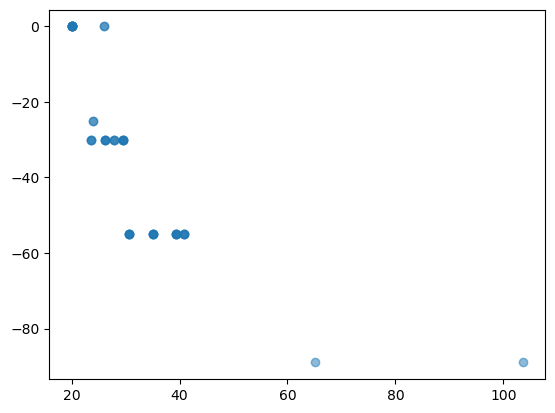

In [120]:
plt.scatter(x = np.array([sol.tour_cost for sol in init_pop]), y = -np.array([sol.packing_plan_cost for sol in init_pop]), alpha = 0.5)

In [207]:
import pandas as pd
import numpy as np
city_count = 280
node_info = pd.read_table('a280-n1395_city.txt', delim_whitespace=True)
node_info.info
test = np.power(4,2)
test = np.sqrt(test)
test
x = np.power(node_info['X'][1]-node_info['X'][0],2)
y = np.power(node_info['Y'][1]-node_info['Y'][0],2)
distance = np.sqrt(x+y)
distance
distanceMatrix = np.zeros((city_count,city_count))
for i in range(city_count):
    for j in range(city_count):
        x = np.power(node_info['X'][i]-node_info['X'][j],2)
        y = np.power(node_info['Y'][i]-node_info['Y'][j],2)
        distance = np.sqrt(x+y)
        distanceMatrix[i][j] = distance
distanceMatrix

array([[ 0.        , 20.        , 24.08318916, ..., 43.26661531,
        34.40930107, 17.88854382],
       [20.        ,  0.        , 18.43908891, ..., 36.22154055,
        28.        ,  8.94427191],
       [24.08318916, 18.43908891,  0.        , ..., 19.6977156 ,
        10.77032961, 10.        ],
       ...,
       [43.26661531, 36.22154055, 19.6977156 , ...,  0.        ,
         8.94427191, 29.12043956],
       [34.40930107, 28.        , 10.77032961, ...,  8.94427191,
         0.        , 20.39607805],
       [17.88854382,  8.94427191, 10.        , ..., 29.12043956,
        20.39607805,  0.        ]])

In [218]:
init_pop = []
for i in range(100):
    if i % 10 == 0:
        print(i)
    candidate_solution = structure()
    candidate_solution.tour = nearest_neighbour_2opt(distanceMatrix)
    init_pop.append(candidate_solution)

0
10
20
30
40
50
60
70
80
90


In [220]:
print(min([tour_length(init_pop[i].tour, distanceMatrix) for i in range(len(init_pop))]))

3070.68242425079
